# Análise Exploratória

# Dicionário dos Dados

|Atributo|Tipo|Descrição|
|-------|----|-----------|
|uid|int64| Identificador único do cliente|
|country|object| País do cliente|
|gender|object| Gênero do cliente|
|spent|int64| Total gasto na transação|
|purchases|int64| Número de compras realizadas na transação|
|date|datetime64[ns]| Data da compra|
|group|object| GROUP B (Controle) ->  Manual , GROUP A (Tratamento) -> Automático|
|device |object| Dispositivo em que a compra foi realizada (I-> Site, A -> App)|

# 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats import api as sms
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from src import GeneralUtils as gu
import plotly.express as px
import warnings
from cliffs_delta import cliffs_delta
import pingouin as pg

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')

## 1.1 Load Data

In [4]:
df_raw = pd.read_csv('../data/ab_testing.csv')

In [5]:
df_raw.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


# 2.0 Descrição dos Dados

In [6]:
df1 = df_raw.copy()

## 2.1 Dimensões

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of rows: 45883
Number of Cols: 8


## 2.2 Checando valores faltantes e Tipos de dados

In [8]:
gu.sum_table(df1)

,Name,dtypes,Uniques,Missing,Missing %
0,uid,int64,45883,0,0.0
1,country,object,10,0,0.0
2,gender,object,2,0,0.0
3,spent,int64,641,0,0.0
4,purchases,int64,26,0,0.0
5,date,object,1316,0,0.0
6,group,object,2,0,0.0
7,device,object,2,0,0.0


Não há valores faltantes no dataset.

Não há ids duplicados, ou seja, todos os usuários estão designados para apenas um dos grupos.

## 2.3. Corrigindo Tipos de Dados

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df_aux = df1.copy()
df_aux['year_month'] = df_aux['date'].dt.strftime('%Y-%m')

## 2.4 Estatística Descritiva

In [10]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [11]:
num_att.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'ptp': 'range', 'index': 'attributes'})

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,uid,11115722.0,99999383.0,88883661.0,5.544232e+07,55312026.0,2.558679e+07,0.007913,-1.190403
1,spent,99.0,12170.0,12071.0,1.883453e+03,1596.0,1.363922e+03,1.365817,2.627362
2,purchases,1.0,30.0,29.0,4.544385e+00,4.0,3.102454e+00,1.348301,2.562334


In [12]:
df1.groupby('group')[['spent', 'purchases']].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()

group spent                                          purchases      \
           min    max         mean  median          std       min max   
0  GRP A    99  11176  1880.504281  1596.0  1368.402763         1  25   
1  GRP B    99  12170  1886.419822  1596.0  1359.422437         1  30   

                              
       mean median       std  
0  4.536355    4.0  3.110742  
1  4.552461    4.0  3.094142

In [13]:
num_att.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['spent', 'purchases']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
spent,45883.0,1883.453349,1363.921546,99.0,198.0,299.0,499.0,698.0,1596.0,2891.0,3693.0,4493.0,6385.0,12170.0
purchases,45883.0,4.544385,3.102454,1.0,1.0,1.0,1.0,2.0,4.0,7.0,9.0,11.0,15.0,30.0


## 2.5.1 Spent

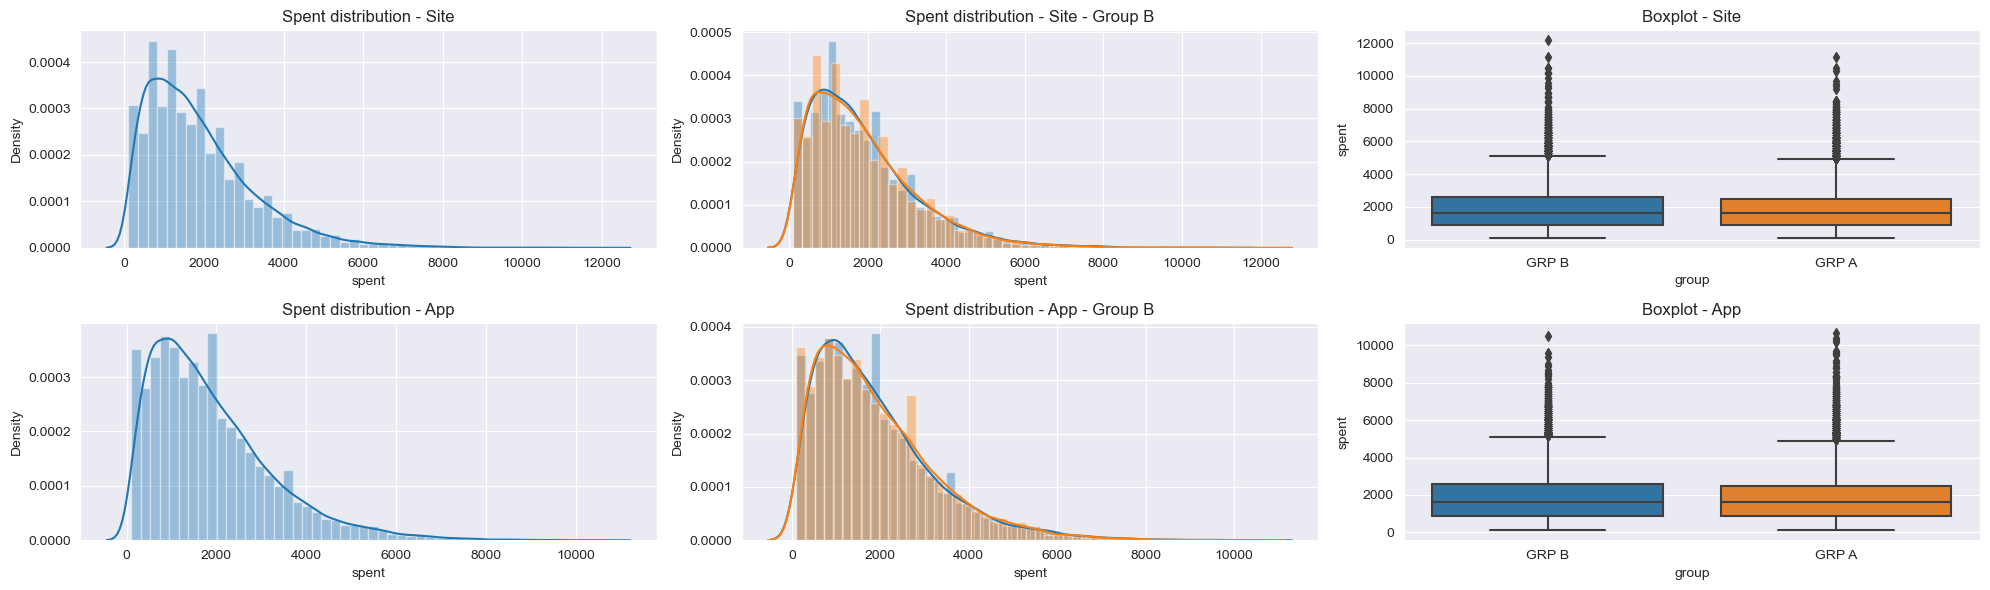

In [21]:
df_site = df1.query("device=='I'")
df_app = df1.query("device=='A'")

plt.figure(figsize=(20, 6))
plt.subplot(2, 3, 1)
plt.title('Spent distribution - Site')
sns.distplot(df_site['spent'], label='group')
plt.subplot(2, 3, 2)
plt.title('Spent distribution - Site - Group A')
sns.distplot(df_site.query("group == 'GRP A'")['spent'], label='Group A')
plt.subplot(2, 3, 2)
plt.title('Spent distribution - Site - Group B')
sns.distplot(df_site.query("group == 'GRP B'")['spent'], label='Group B')
plt.subplot(2, 3, 3)
plt.title('Boxplot - Site')
sns.boxplot(x='group', y='spent', data=df_site)


plt.subplot(2, 3, 4)
plt.title('Spent distribution - App')
sns.distplot(df_app['spent'], label='group')
plt.subplot(2, 3, 5)
plt.title('Spent distribution - App - Group A')
sns.distplot(df_app.query("group == 'GRP A'")['spent'], label='Group A')
plt.subplot(2, 3, 5)
plt.title('Spent distribution - App - Group B')
sns.distplot(df_app.query("group == 'GRP B'")['spent'], label='Group B')
plt.subplot(2, 3, 6)
plt.title('Boxplot - App')
sns.boxplot(x='group', y='spent', data=df_app)
plt.tight_layout()

Analisando a distribuição dos gastos por dispositivo, o grupo controle e de tratamento são bem parecidos. Mas precisamos analisar a significância estatística.

**Boxplots**

Agora, iremos analisar os boxplots dos gastos do grupo controle e tratamento em cada país separados pelo tipo de dispositivo.

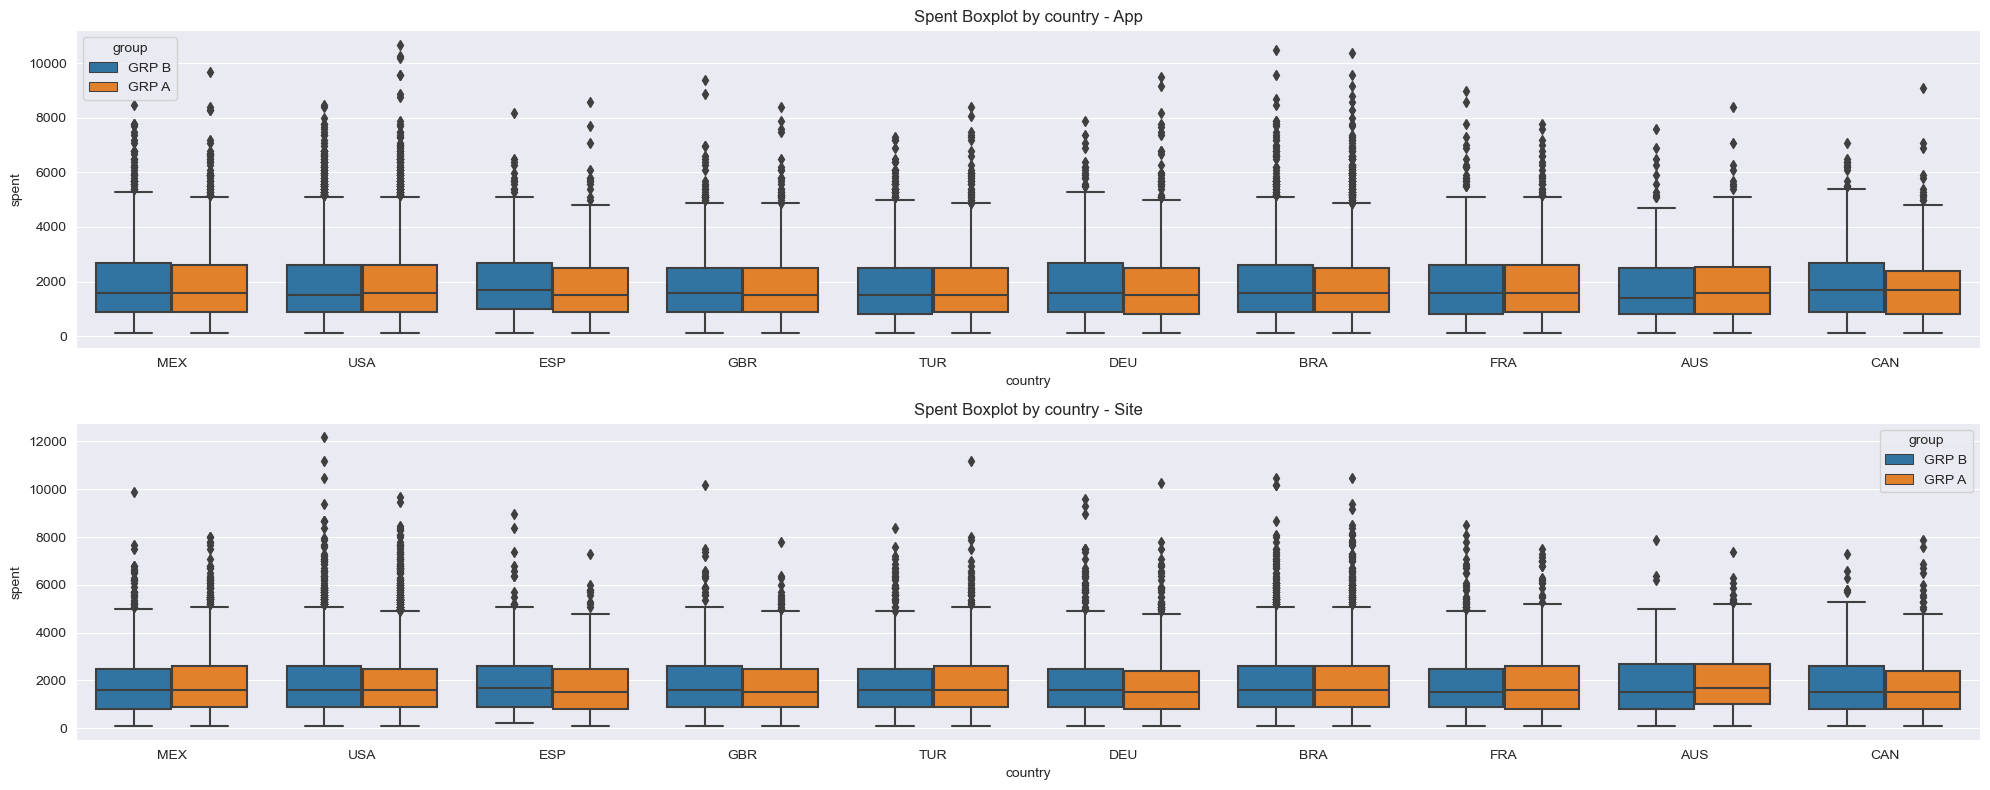

In [22]:
countries = df1.country.unique()
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title('Spent Boxplot by country - App')
sns.boxplot(x='country', y='spent', hue='group', data=df_app, order=countries);
plt.subplot(2, 1, 2)
plt.title('Spent Boxplot by country - Site')
sns.boxplot(x='country', y='spent', hue='group', data=df_site, order=countries);
plt.tight_layout()

O grupo controle e de tratameto são bem parecidos em todos os casos analisados.

**Checando presença de valores extremos**

Valores muito extremos podem impactar nos resultados do teste, então é importante tratá-los antes realizarmos o teste de hipótese.

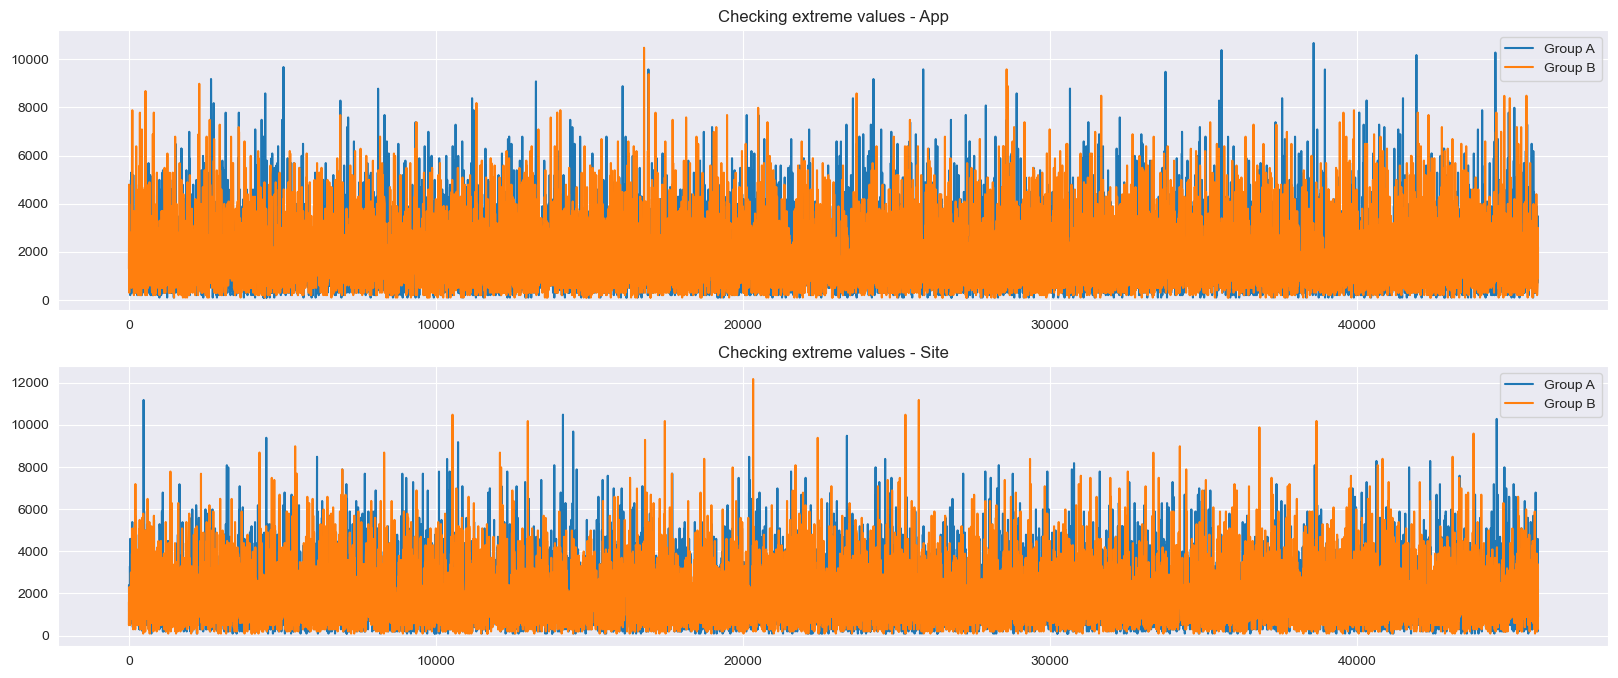

In [23]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title('Checking extreme values - App')
df_app.query("group == 'GRP A'").spent.plot(label='Group A')
df_app.query("group == 'GRP B'").spent.plot(label='Group B')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Checking extreme values - Site')
df_site.query("group == 'GRP A'").spent.plot(label='Group A')
df_site.query("group == 'GRP B'").spent.plot(label='Group B')
plt.legend()
plt.show()

Aparentemente não há valores muito extremos que atrapalhariam o nosso teste.

## 2.5.1 Purchases

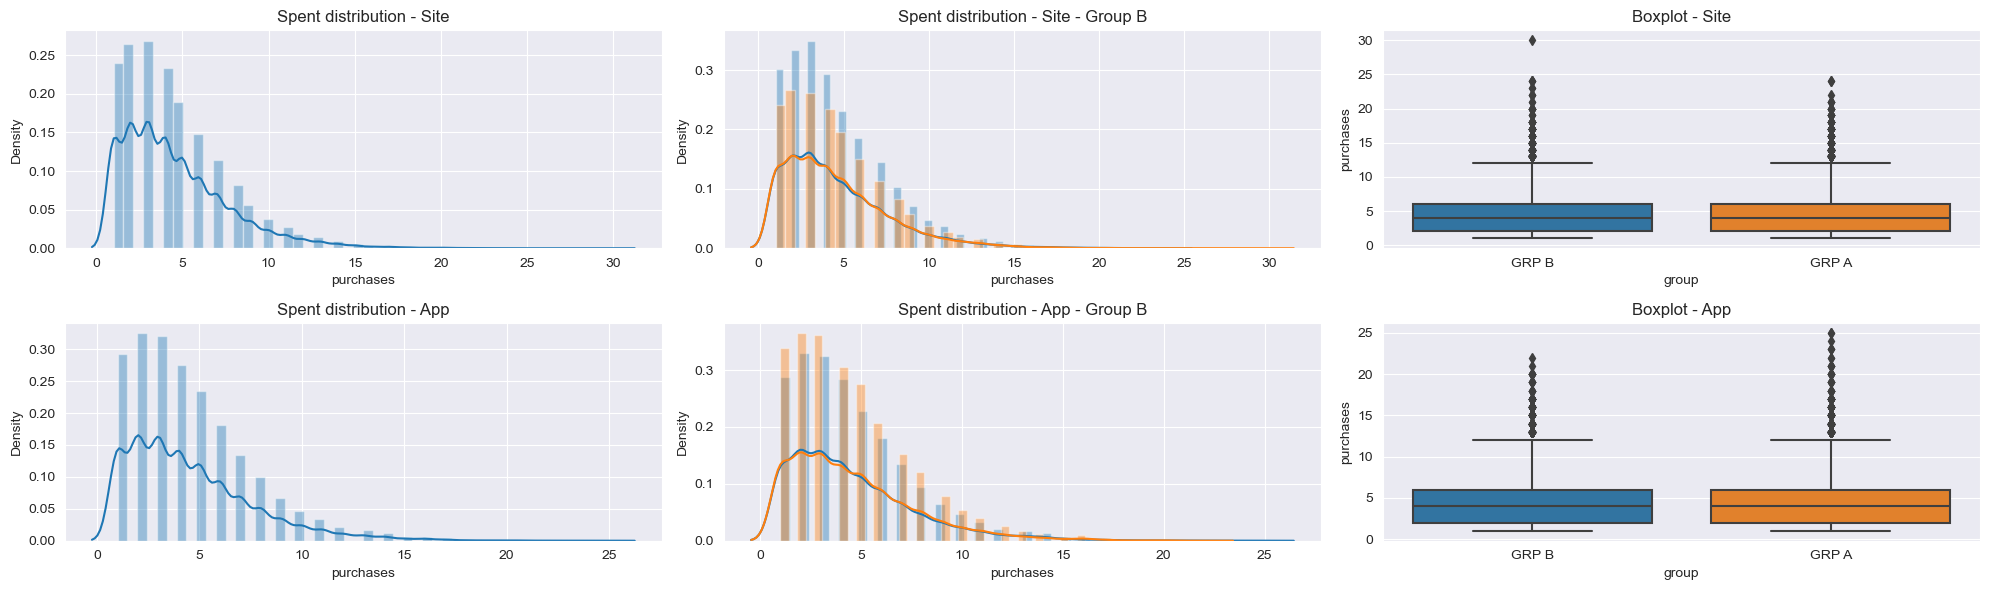

In [24]:
df_site = df1.query("device=='I'")
df_app = df1.query("device=='A'")

plt.figure(figsize=(20, 6))
plt.subplot(2, 3, 1)
plt.title('Spent distribution - Site')
sns.distplot(df_site['purchases'], label='group')
plt.subplot(2, 3, 2)
plt.title('Spent distribution - Site - Group A')
sns.distplot(df_site.query("group == 'GRP A'")['purchases'], label='Group A')
plt.subplot(2, 3, 2)
plt.title('Spent distribution - Site - Group B')
sns.distplot(df_site.query("group == 'GRP B'")['purchases'], label='Group B')
plt.subplot(2, 3, 3)
plt.title('Boxplot - Site')
sns.boxplot(x='group', y='purchases', data=df_site)


plt.subplot(2, 3, 4)
plt.title('Spent distribution - App')
sns.distplot(df_app['purchases'], label='group')
plt.subplot(2, 3, 5)
plt.title('Spent distribution - App - Group A')
sns.distplot(df_app.query("group == 'GRP A'")['purchases'], label='Group A')
plt.subplot(2, 3, 5)
plt.title('Spent distribution - App - Group B')
sns.distplot(df_app.query("group == 'GRP B'")['purchases'], label='Group B')
plt.subplot(2, 3, 6)
plt.title('Boxplot - App')
sns.boxplot(x='group', y='purchases', data=df_app)

plt.tight_layout()

**Boxplots**

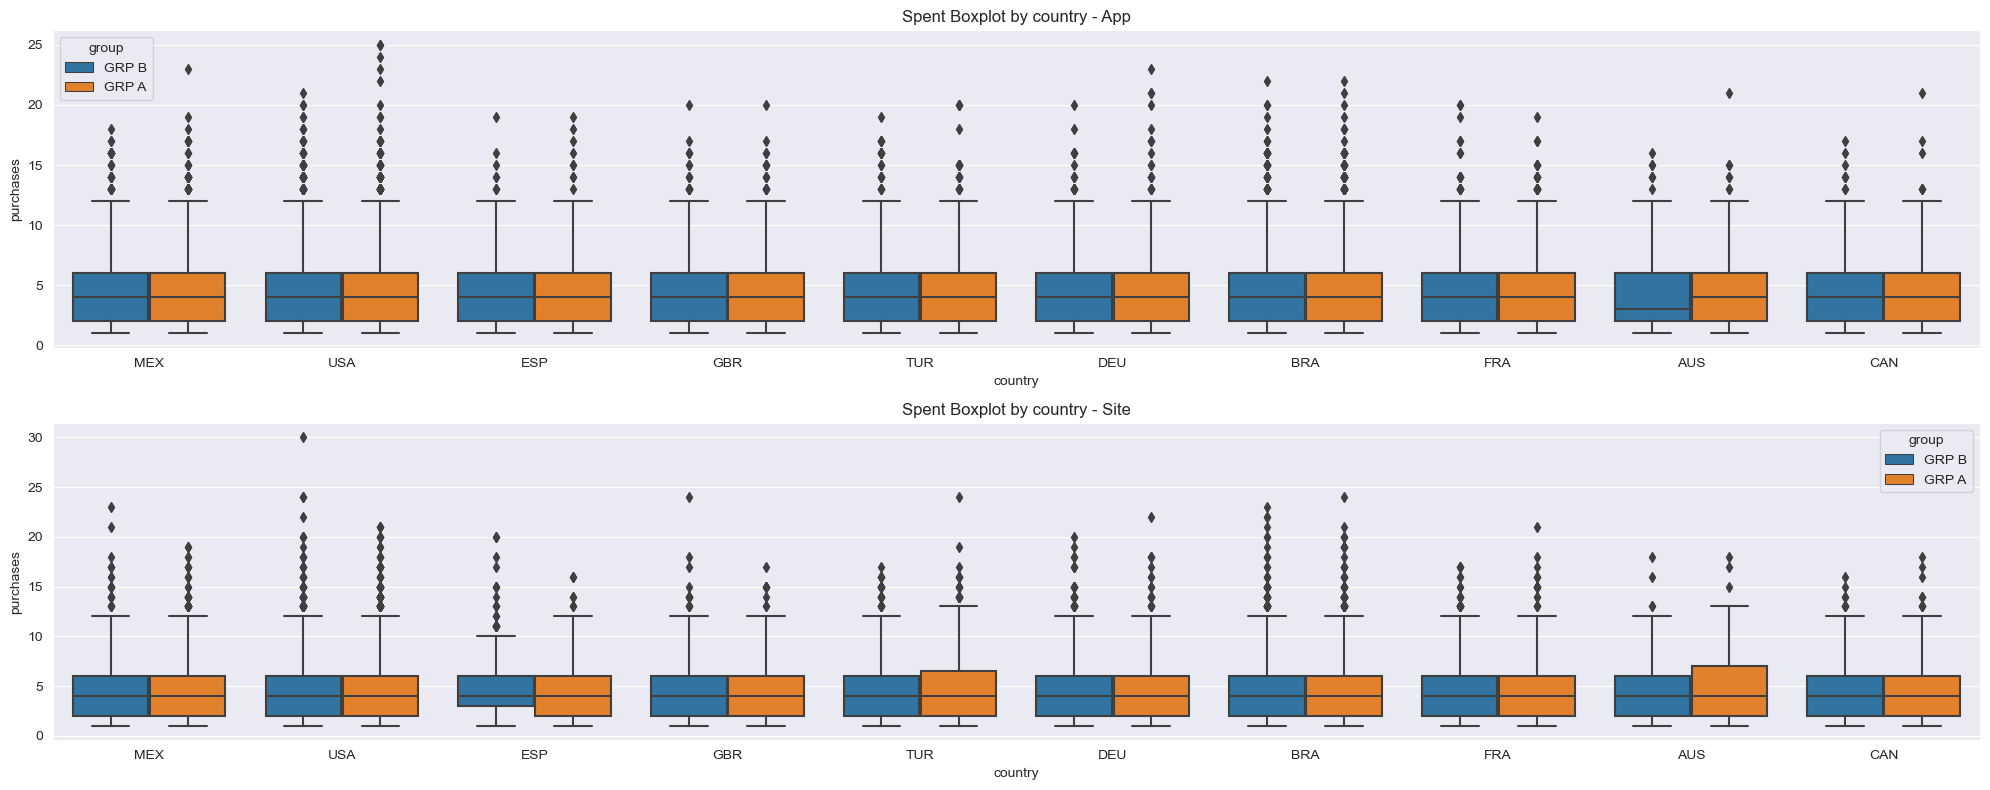

In [25]:
countries = df1.country.unique()
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title('Spent Boxplot by country - App')
sns.boxplot(x='country', y='purchases', hue='group', data=df_app, order=countries);
plt.subplot(2, 1, 2)
plt.title('Spent Boxplot by country - Site')
sns.boxplot(x='country', y='purchases', hue='group', data=df_site, order=countries);
plt.tight_layout()

Como na variável gastos, o número compras dos grupos de controle e tratamento são semelhantes em cada país. 

**Checando presença de valores extremos**

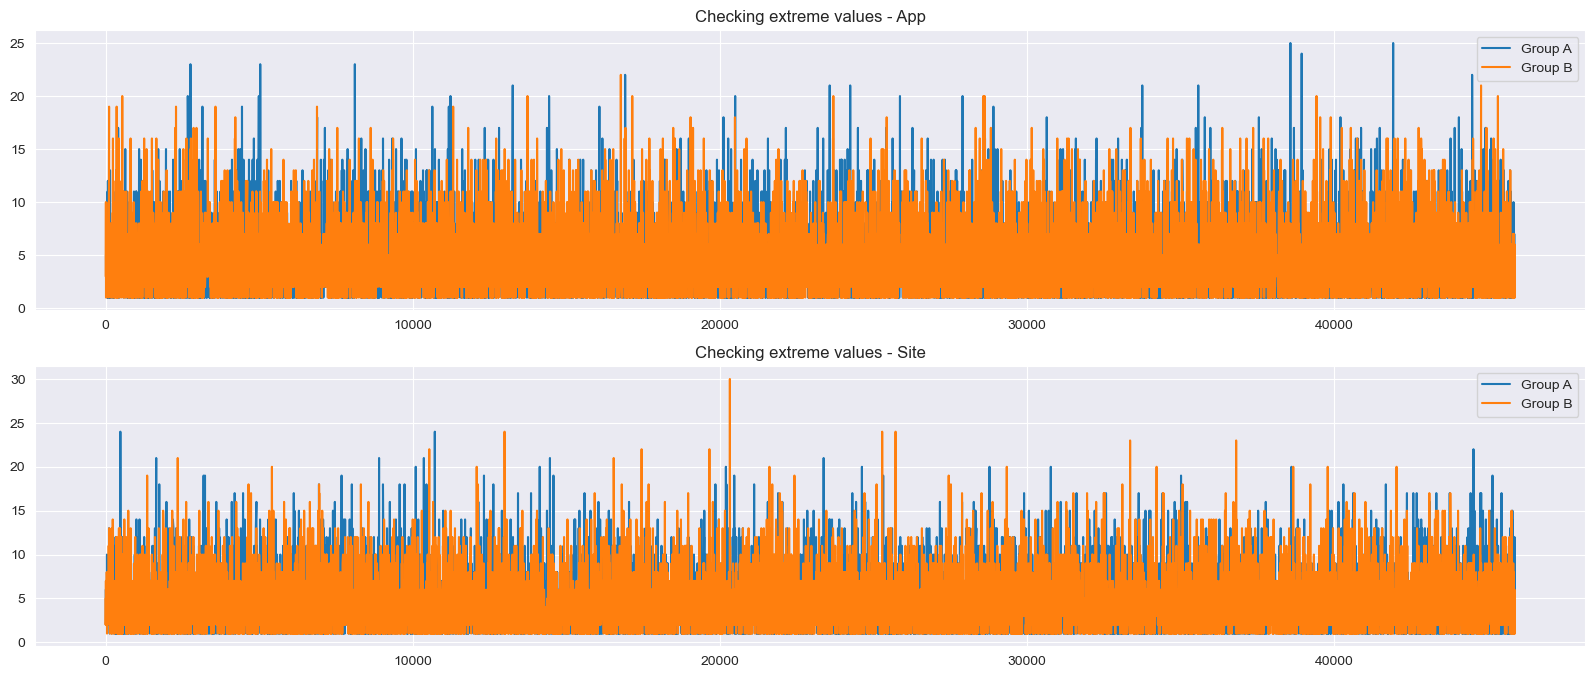

In [26]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title('Checking extreme values - App')
df_app.query("group == 'GRP A'").purchases.plot(label='Group A')
df_app.query("group == 'GRP B'").purchases.plot(label='Group B')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Checking extreme values - Site')
df_site.query("group == 'GRP A'").purchases.plot(label='Group A')
df_site.query("group == 'GRP B'").purchases.plot(label='Group B')
plt.legend()
plt.show()

Aparentemente não há valores muito extremos que atrapalhariam o nosso teste.

## 2.5 Proporção dos Grupos

In [27]:
df1['group'].value_counts(normalize=True)

GRP A    0.501471
GRP B    0.498529
Name: group, dtype: float64

In [28]:
df1['device'].value_counts(normalize=True)

A    0.500883
I    0.499117
Name: device, dtype: float64